In [1]:
import pandas
import konlpy
import gensim
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

## 데이터 준비

In [2]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 9996

def load_data(train_data, test_data, num_words=num_words):
    # 중복데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 결측치 제거
    train_data.dropna(how='any', inplace=True)
    test_data.dropna(how='any', inplace=True)
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    # 사전 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    # 가장 많이 나온 단어 9996개
    counter = counter.most_common(10000-4)
    # 앞의 4개는 특수토큰
    vocab = ['<PAD>', '<UNK>', '<SOS>', '<EOS>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 인코딩용
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return (X_train, np.array(list(train_data['label']))), (X_test, np.array(list(test_data['label']))), word_to_index

(x_train, y_train), (x_test, y_test), word_to_index = load_data(train_data, test_data)

In [4]:
# 디코딩 용
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <SOS>로 시작하는 것으로 간주
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<SOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] for index in encoded_sentence[1:])

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공
+ 문자 최대 길이 지정
+ 패딩 추가

In [6]:
# 텍스트데이터 문장길이의 리스트를 생성(SOS토큰은 제거)
length_sequences = [len(sequence) - 1 for sequence in x_train]
length_sequences = np.array(length_sequences)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(length_sequences))
print('문장길이 최대 : ', np.max(length_sequences))
print('문장길이 표준편차 : ', np.std(length_sequences))

# 예를들어, 최대 길이를 (평균 + 2.5*표준편차)로 한다면,
max_length = np.mean(length_sequences) + 2.5 * np.std(length_sequences)
max_length = int(max_length)
print('pad_sequences max length : ', max_length)
print(f'전체 문장의 {np.sum(length_sequences < max_length) / len(length_sequences) * 100}%가 maxlen 설정값 이내에 포함.')

# 95번째 백분위수로 최대길이 지정
# max_length = int(np.percentile(length_sequences, 95.49))
# print(max_length)

문장길이 평균 :  14.98170773419436
문장길이 최대 :  115
문장길이 표준편차 :  12.82473766384545
pad_sequences max length :  47
전체 문장의 95.22923478950896%가 maxlen 설정값 이내에 포함.


In [7]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=max_length)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=max_length)

print(x_train.shape)

(146182, 47)


## 모델학습 1

In [8]:
vocab_size = 10000
# 이후 사전학습 임베딩 모델과 차원을 맞춰주기 위해 100으로 설정
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(47,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 47, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 3488      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 검증세트로 대략 20퍼센트 분리
x_val = x_train[:30000]
y_val = y_train[:30000]

# validation set을 제외한 나머지 15000건
x_train = x_train[30000:]  
y_train = y_train[30000:]

print(x_train.shape)
print(y_train.shape)

(116182, 47)
(116182,)


In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
epochs=16

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)

In [12]:
# 테스트 점수 출력
results = model.evaluate(x_test,  y_test, verbose=0)

print(results)

[0.5513007640838623, 0.8359134793281555]


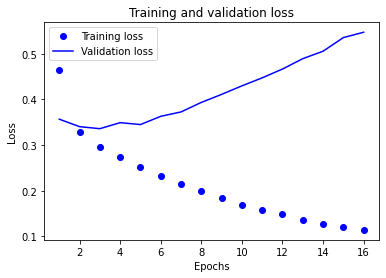

In [13]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, train_loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 모델학습 2
+ 위 모델이 조금 빠르게 과대적합된 면이 있어서 드롭아웃 층을 추가했다.

In [14]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(47,)))
model2.add(tf.keras.layers.LSTM(8))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 47, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
____________________________________________

In [15]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
epochs=16

history2 = model2.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)

In [17]:
# 테스트 점수 출력
results = model2.evaluate(x_test,  y_test, verbose=0)

print(results)

[0.5279307961463928, 0.8447016477584839]


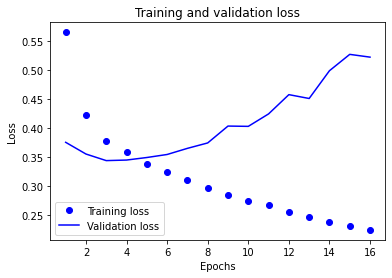

In [18]:
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, train_loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 모델훈련 3
+ 어느 정도 개선이 됐지만 그래도 아쉬운 성능이다.
+ 모델 용량을 늘리고 옵티마이저는 RMSProp, 에포크 수를 늘리고 조기종료까지 해보자.

In [19]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(47,)))
# LSTM 층 추가
model3.add(tf.keras.layers.LSTM(16, return_sequences=True)) # 다음층도 LSTM이므로 모든 스텝마다 은닉상태 전달
model3.add(tf.keras.layers.LSTM(8))
model3.add(tf.keras.layers.Dropout(0.5))
# 은닉층 뉴런 수 증가 (8 → 16)
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 47, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 47, 16)            7488      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [20]:
# 조기 종료 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4, # 4번의 에포크동안 개선이 없으면 종료
    restore_best_weights=True
)

model3.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history3 = model3.fit(x_train,
                      y_train,
                      epochs=30,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      callbacks=[early_stopping],
                      verbose=0
)

In [21]:
results = model3.evaluate(x_test,  y_test, verbose=0)

print(results)

[0.3364587426185608, 0.853062629699707]


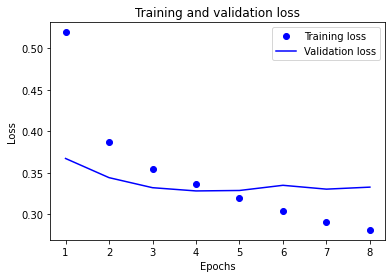

In [22]:
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, train_loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 한국어 Word2Vec 임베딩 활용하여 성능 개선
하이퍼 파라미터를 튜닝하여 나름 만족할만한 개선을 이루어낸 것 같다.
이제 한국어 Word2Vec 임베딩을 활용하여 조금 더 성능을 개선해보자.

In [23]:
# 사전학습된 한국어 Word2Vec 모델 가져오기
word2vec_ko_path = os.getenv('HOME')+'/data/word2vec_ko.model'
ko_model = Word2Vec.load(word2vec_ko_path)
ko_vectors = ko_model.wv

# 임베딩 매트릭스 생성
embedding_matrix = np.zeros((vocab_size, word_vector_dim))

# 공통 단어에 대해 사전학습된 임베딩 값 복사
for i in range(4, vocab_size):  # 특수 토큰 제외
    word = index_to_word[i]
    if word in ko_vectors:
        embedding_matrix[i] = ko_vectors[word]
    # 없는 단어는 0벡터로 유지

# 한국어 사전학습 w2v 모델 사용
model_w2v = tf.keras.Sequential()
model_w2v.add(tf.keras.layers.Embedding(vocab_size,
                                        word_vector_dim,
                                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                        trainable=True,  # 파인튜닝(없는 단어도 학습)
                                        input_shape=(47,))
)
# 이후 모델3와 동일
model_w2v.add(tf.keras.layers.LSTM(16, return_sequences=True)) # 다음층도 LSTM이므로 모든 스텝마다 은닉상태 전달
model_w2v.add(tf.keras.layers.LSTM(8))
model_w2v.add(tf.keras.layers.Dropout(0.5))
model_w2v.add(tf.keras.layers.Dense(16, activation='relu'))
model_w2v.add(tf.keras.layers.Dropout(0.5))
model_w2v.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 47, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 47, 16)            7488      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [24]:
# 조기 종료 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4, # 4번의 에포크동안 개선이 없으면 종료
    restore_best_weights=True
)

model_w2v.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history4 = model_w2v.fit(x_train,
                      y_train,
                      epochs=30,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      callbacks=[early_stopping],
                      verbose=0
)

In [25]:
results = model_w2v.evaluate(x_test,  y_test, verbose=0)

print(results)

[0.33739981055259705, 0.8560733795166016]


테스트셋에 대해 감성분석 정확도 85%를 달성했다.

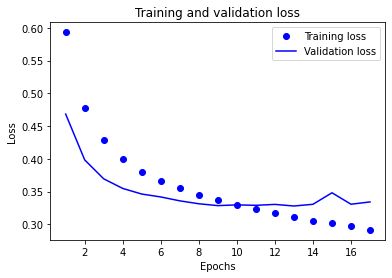

In [26]:
train_acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, train_loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

사전학습된 모델은 우리의 task에 최적화된 모델이 아니기에 초반 loss는 높은 걸 확인할 수 있다. 그리고 학습을 통해 파인튜닝하여 최적점을 찾아가는 모습이다.

## 학습된 Embedding Layer와 사전학습된 W2V 비교분석

In [27]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록 
vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
# 재미에 대한 임베딩 벡터 출력
vector = word_vectors['재미']
vector

array([ 4.26183678e-02, -3.80998664e-03, -5.44796092e-03, -2.83974204e-02,
        8.24745372e-02, -3.18700187e-02, -1.87006846e-01,  6.42808601e-02,
        1.63566098e-02,  4.32692021e-02,  7.13987425e-02,  8.44791979e-02,
       -3.00650019e-02,  8.27155039e-02,  3.70950438e-02, -1.52603649e-02,
       -3.65696140e-02, -2.41029486e-02,  1.37392297e-01,  6.17831051e-02,
        1.71684176e-02,  1.70636866e-02,  2.24639289e-02, -1.12786144e-02,
       -9.53260586e-02,  1.32895075e-02, -1.10634812e-03,  4.96632280e-03,
        4.54577208e-02,  4.19912534e-03,  2.24992502e-02, -5.16327433e-02,
       -3.86069678e-02, -4.71207276e-02, -7.42425993e-02,  1.75656810e-01,
       -9.42245591e-03, -7.34341517e-02, -1.86882671e-02, -8.04029033e-02,
        4.64935340e-02, -5.95331118e-02,  4.51091938e-02,  2.24639401e-02,
        4.77222167e-03, -4.20871750e-02,  1.36096343e-01,  8.55394453e-02,
        2.51043867e-02,  6.75039813e-02, -9.43764672e-02,  6.12974130e-02,
        1.48327753e-01, -

영화와 관련된 텍스트인 재미, 눈물, 배우라는 키워드로 각 단어와 유사한 단어들을 비교해보았다.
사전학습된 임베딩 모델이 훨씬 유사한 단어를 많이 보여준 것을 확인할 수 있었다.

재미

In [29]:
print(word_vectors.similar_by_word('재미'))

[('너무', 0.8360869884490967), ('완전', 0.7940289378166199), ('이리', 0.7923863530158997), ('넘', 0.7525584697723389), ('가치', 0.7518238425254822), ('이렇게', 0.7510848641395569), ('스릴', 0.7242820262908936), ('흥미', 0.7062549591064453), ('연기력', 0.7021557688713074), ('왤케', 0.7018789649009705)]


In [30]:
print(ko_vectors.most_similar('재미', topn=10))

[('묘미', 0.6163142919540405), ('취미', 0.6034970283508301), ('흥미', 0.5939850211143494), ('유머', 0.5888698101043701), ('보람', 0.5689517259597778), ('즐거움', 0.5631207823753357), ('개그', 0.5552946329116821), ('이야기', 0.5536993741989136), ('연애', 0.552293598651886), ('열의', 0.546456515789032)]


눈물

In [31]:
print(word_vectors.similar_by_word('눈물'))

[('very', 0.945076048374176), ('멋져요', 0.943089485168457), ('짱짱', 0.9429879784584045), ('명화', 0.9410014152526855), ('완소', 0.9408244490623474), ('명불허전', 0.9401829242706299), ('즐거웠', 0.9389277696609497), ('멋져', 0.93860924243927), ('명작', 0.9385954141616821), ('good', 0.9384078979492188)]


In [32]:
print(ko_vectors.most_similar('눈물', topn=10))

[('웃음', 0.7543492317199707), ('슬픔', 0.7267216444015503), ('한숨', 0.7182712554931641), ('피눈물', 0.7141152024269104), ('땀', 0.7121106386184692), ('이별', 0.695806622505188), ('가슴', 0.6698150038719177), ('기쁨', 0.657920241355896), ('머리카락', 0.6576725840568542), ('꿈', 0.6558417677879333)]


배우

In [33]:
print(word_vectors.similar_by_word('배우'))

[('이렇게', 0.5109687447547913), ('보여', 0.4939647912979126), ('예술', 0.48783910274505615), ('너무', 0.48567572236061096), ('재미', 0.4850325584411621), ('는군요', 0.47953104972839355), ('기에', 0.46994248032569885), ('기대', 0.46984878182411194), ('쟈', 0.4682946801185608), ('바로', 0.4670015275478363)]


In [34]:
print(ko_vectors.most_similar('배우', topn=10))

[('가수', 0.7729029655456543), ('코미디언', 0.7728644609451294), ('만화가', 0.749615490436554), ('영화배우', 0.7441834211349487), ('여배우', 0.7411354184150696), ('연출가', 0.7396705746650696), ('극작가', 0.7209770679473877), ('삽화가', 0.7152643799781799), ('안무가', 0.7149248123168945), ('무용가', 0.7118033766746521)]


## 회고
+ 텍스트를 다루는 건 생각보다 신경쓸 부분이 많은 것 같다.
+ 확실히 사전학습 임베딩 모델이 좋긴하다.
+ 드롭아웃도 신경망에선 굉장히 중요한 것 같다. 드롭아웃만 적용해도 과대적합이 많이 줄었다.